In [1]:
!which python

/Users/aaron/Documents/github/ssdmultibox/venv/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cpu')

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-2

criterion = SSDLoss(alpha=.2)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
current_time = time.time()

In [7]:
TrainPascalFlatDataset.__len__ = lambda self: 4

train_dataset = TrainPascalFlatDataset()

len(train_dataset)

4

In [8]:
train_dataset

In [9]:
NUM_WORKERS = utils.get_cpu_count()

# if platform.system() == 'Darwin': # Mac
#     BATCH = 4
#     SHUFFLE = False
# else:
#     BATCH = 32
#     SHUFFLE = True

BATCH = 4
SHUFFLE = False
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

In [10]:
EPOCHS = 1

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 112.5413 neg_hard_mining_loss: 354.2793
n: 37.0 bbs_loss: 544.2158 cats_loss: 466.8207
epoch: 0 step: 0 loss: 27.3253 time: 12.5589



In [11]:
bbs_preds, cats_preds = preds

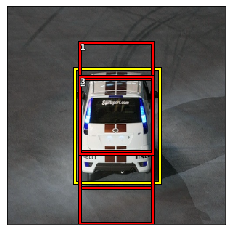

In [12]:
from ssdmultibox.plotting import *

idx = 0
dataset = train_dataset

plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

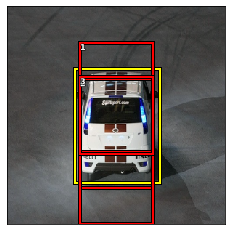

In [13]:
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

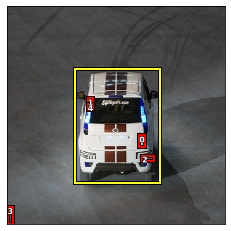

In [14]:
plot_nms_preds(dataset, image_ids, idx, preds, limit=5)